In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
sys.path.append("./RNN_scripts")
from DE_library import simulate_ODE, simulate_trajectories
import matplotlib.pyplot as plt
from example_utils import reject_outliers, initial_conditions, plot_phase_portrait

from MARBLE import utils, geometry, net, plotting, postprocessing, compare_attractors

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def simulate_system(mu, X0, t):
    p, v = simulate_trajectories('vanderpol', X0, t, par = {'mu': mu})
    pos, vel = [], []
    for p_, v_ in zip(p,v):
        ind = reject_outliers(p_, v_)
        pos.append(p_[ind])
        vel.append(v_[ind])
        
    return pos, vel

def parabola(X, Y, alpha=0.05):
    Z = -(alpha*X)**2 -(alpha*Y)**2
    
    return np.column_stack([X.flatten(), Y.flatten(), Z.flatten()])

# For initial conditions, sample a rectangle uniformly

In [5]:
t0, t1, dt = 0, 3, 0.5
t = np.arange(t0, t1, dt)
n = 100
area = [[-3,-3],[3,3]]

# Geneate phase portraits from random initial conditions while varying $\beta_1$

In [6]:
n_steps=20
beta1 = np.hstack((np.linspace(-.5,.5,n_steps)))

pos, vel = [], []
X0_range = initial_conditions(n, len(beta1), area)
for i, b1 in enumerate(beta1):
    p, v = simulate_system(b1, X0_range[i], t)
            
    pos.append(np.vstack(p))
    vel.append(np.vstack(v))
    
#embed on parabola
for i, (p, v) in enumerate(zip(pos, vel)):
    end_point = p + v
    new_endpoint = parabola(end_point[:,0], end_point[:,1])
    pos[i] = parabola(p[:,0], p[:,1])
    vel[i] = new_endpoint - pos[i]

/mnt/scratch/lts2/gosztolai/miniconda3/envs/MARBLE/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Plot vector fields

In [12]:
data = utils.construct_dataset(pos, features=vel, graph_type='cknn', k=20, n_geodesic_nb=30, stop_crit=0.03, vector=False)

---- Embedding dimension: 3
---- Signal dimension: 3


Vector computations are disabled


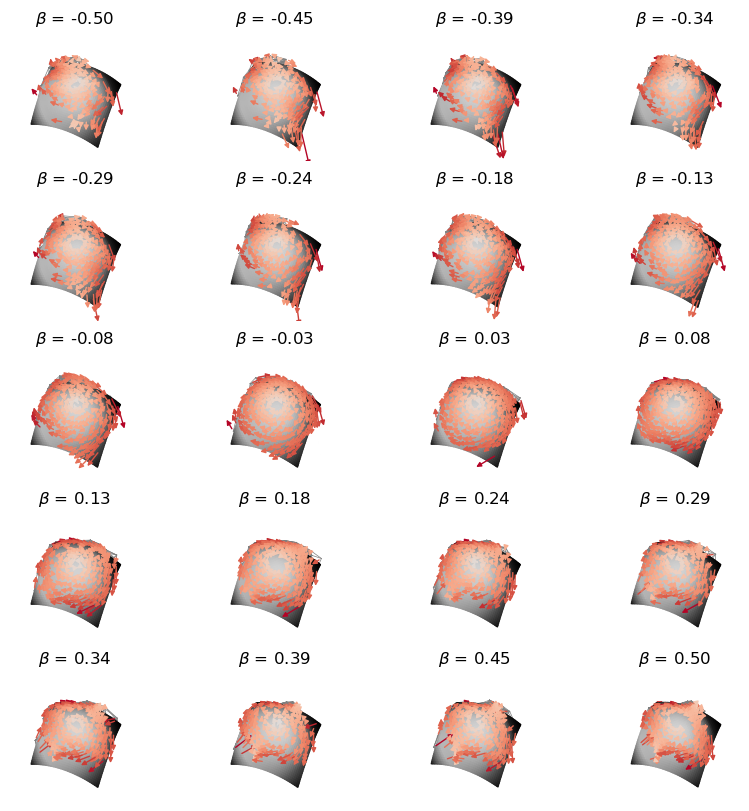

In [28]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]

#plotting.fields(data, col=4, alpha=0.3, scale=10)
axes = plotting.fields(data, col=4, alpha=1, width=7, scale=2, titles=titles, view=[70,20])

from matplotlib.colors import LightSource

x = y = np.arange(-3.0, 3.0, 0.05)
X, Y = np.meshgrid(x, y)
xyz = np.array(parabola(np.ravel(X), np.ravel(Y)))
ls = LightSource(azdeg=30,altdeg=30)
rgb = ls.shade(xyz[:,2].reshape(X.shape)-0.1, plt.cm.gray)

for ax in axes:
    ax.plot_surface(xyz[:,0].reshape(X.shape), xyz[:,1].reshape(X.shape), xyz[:,2].reshape(X.shape)-0.02, 
                color='gray', 
                shade=True,
                lightsource=ls,
                facecolors=rgb
               )
#plt.savefig('./outputs/parabolas.svg')

# Train network

In [65]:
par = {'epochs': 75, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 4,
       'inner_product_features': True,
      }

model = net(data, **par)
model.run_training(data)


---- Settings: 

epochs : 75
order : 2
hidden_channels : 32
out_channels : 4
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
autoencoder : False
diffusion : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  698

---- Training network ...

Epoch: 1, Training loss: 1.3747, Validation loss: 1.3575, lr: 0.0100 *
Epoch: 2, Training loss: 1.3151, Validation loss: 1.2346, lr: 0.0100 *
Epoch: 3, Training loss: 1.1804, Validation loss: 1.1588, lr: 0.0100 *
Epoch: 4, Training loss: 1.1566, Validation loss: 1.1763, lr: 0.0100
Epoch: 5, Training loss: 1.1416, Validation loss: 1.1348, lr: 0.0100 *
Epoch: 6, Training loss: 1.1232, Validation loss: 1.1453, lr: 0.0100
Epoch: 7, Training loss: 1.1199, Validation loss: 1.1325, lr: 0.0100 *
Epoch: 8, Training loss: 1.0990, Valid

# Create embeddings

Performed umap embedding on embedded results.
Performed MDS embedding on embedded results.


<AxesSubplot:>

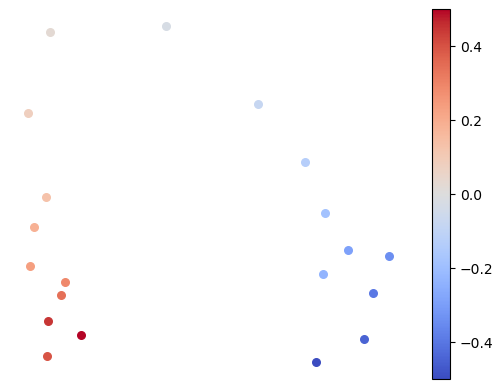

In [66]:
data = model.evaluate(data)
n_clusters=40
data = postprocessing(data, n_clusters=n_clusters)

emb_MDS, _ = geometry.embed(data.dist, embed_typ = 'MDS')
plotting.embedding(emb_MDS, beta1, s=30, alpha=1)
#plt.savefig('../results/van_der_pol_MDS.svg')

# Distance matrix

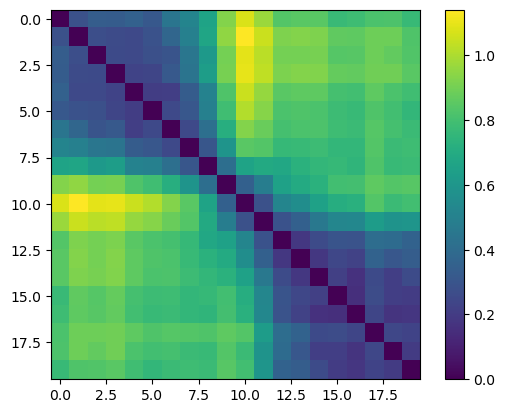

In [67]:
im = plt.imshow(data.dist)
plt.colorbar(im)
#plt.savefig('../results/van_der_pol_D.svg')

# Cluster and visualise embedding

<AxesSubplot:>

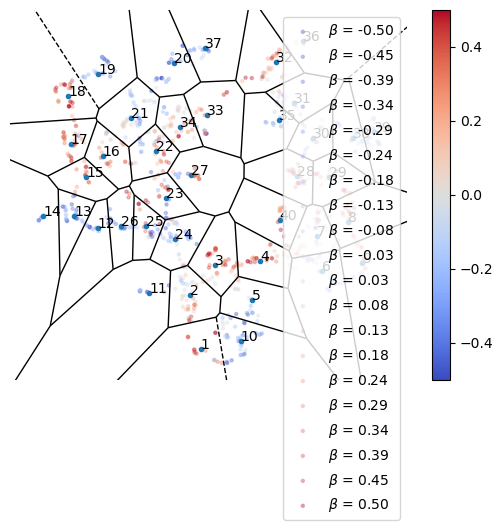

In [68]:
titles = [r'$\beta$ = {:0.2f}'.format(b) for b in beta1]
plotting.embedding(data, beta1[data.y.numpy().astype(int)], titles=titles)
#plt.savefig('../results/van_der_pol_embedding.svg')